In [1]:
import numpy as np
import matplotlib.pyplot as plt

from correlator.helpers.simulation import GaussianSimulator
from correlator.correlator import ContextualCorrelator

## Contextualized Correlation with Multivariate Gaussians

In [44]:
p = 3  # Network dimension p^2
k = 2  # Number of true archetypes
k_n = 100  # Number of samples per archetype

sim = GaussianSimulator(p, k, c, ctype='self')
c = sim.c  # Context dimension, set to k*p*(p+1) when ctype=self
C_train, X_train = sim.gen_samples(k_n)
C_test, X_test = sim.gen_samples(k_n)
C_val, X_val = sim.gen_samples(k_n)
C_train.shape, X_train.shape

((200, 12), (200, 3))

In [45]:
model = ContextualCorrelator(c, p, p, num_archetypes=k*p**2, encoder_width=25, encoder_layers=4, final_dense_size=100, bootstraps=3)
print(f'Starting MSE: {model.get_mse(C_test, X_test, X_test, all_bootstraps=False)}')
model.fit(C_train, X_train, X_train, 100, 1, es_patience=5, es_epoch=25, validation_set=(C_val, X_val, X_val))
print(f'Stopping MSE: {model.get_mse(C_test, X_test, X_test, all_bootstraps=False)}')
print(f'Stopping Var(MSE): {model.get_mse(C_test, X_test, X_test, all_bootstraps=True).var()}')

Starting MSE: 61.223428090413414


[Val MSE: 0.7999] [Train MSE: 0.0447] [Sample: 6/200] Epoch:  25%|▎| 25/100 [00:27<01:23,
[Val MSE: 0.4474] [Train MSE: 0.3574] [Sample: 8/200] Epoch:  25%|▎| 25/100 [00:35<01:45,
[Val MSE: 0.1363] [Train MSE: 0.1356] [Sample: 8/200] Epoch:  25%|▎| 25/100 [00:45<02:17,


Stopping MSE: 0.5234313209851583
Stopping Var(MSE): 0.0015594579823814158


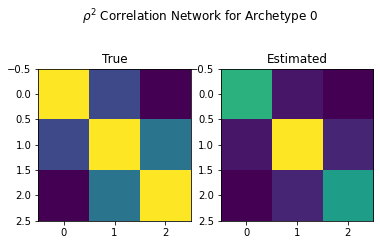

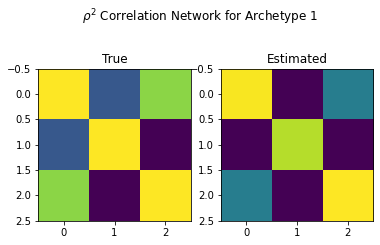

In [46]:
# Plot results
C_plot, X_plot = sim.gen_samples(1)
est_corrs = model.predict_correlation(C_plot, all_bootstraps=False)

for i, true_corr in enumerate(sim.rhos):
    est_corr = est_corrs[i]
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(r'$\rho^2$ Correlation Network for Archetype {k}'.format(k=i))
    axs[0].set_title('True')
    axs[0].imshow(true_corr)
    axs[1].set_title('Estimated')
    axs[1].imshow(est_corr)

In [47]:
# Proportion of explained variance
from correlator.dataset import to_pairwise
mse = model.get_mse(C_train, X_train, X_train)
_, _, x, y = to_pairwise(C_train, X_train, X_train)
x = x.detach().numpy()
y = y.detach().numpy()
explained_var = 1 - mse / np.var(y)
print(f"Proportion of data variance explained by our model: {np.round(explained_var, 3)}")

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x.reshape(-1, 1), y)
fx_global = reg.predict(x.reshape(-1, 1))
mse = np.mean(np.square(fx_global - y))
explained_var = 1 - mse / np.var(y)

print(f"Proportion of data variance explained by global regression: {np.round(explained_var, 3)}")

Proportion of data variance explained by our model: 0.892
Proportion of data variance explained by global regression: 0.014


## Dynamic Correlation with Simple Functions

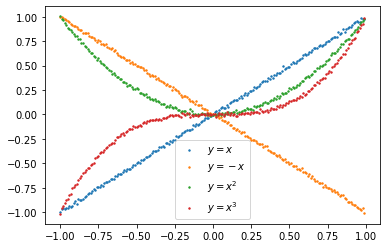

In [48]:
x_low, x_high, n = -1, 1, 200
x = np.arange(x_low, x_high, (x_high - x_low) / n)
C = x.reshape((len(x), 1))
X = np.array([x + np.random.normal(0, .01, n), 
              -x + np.random.normal(0, .01, n),
              x**2 + np.random.normal(0, .01, n),
              x**3 + np.random.normal(0, .01, n),
             ]
            ).T

plt.scatter(C[:,0], X[:,0], s=2, label=r'$y=x$')
plt.scatter(C[:,0], X[:,1], s=2, label=r'$y=-x$')
plt.scatter(C[:,0], X[:,2], s=2, label=r'$y=x^2$')
plt.scatter(C[:,0], X[:,3], s=2, label=r'$y=x^3$')
plt.legend()
plt.show()

In [49]:
idx = np.arange(len(X))
np.random.shuffle(idx)
split = int(.2 * len(X))
train_idx = idx[:-split]
test_idx = idx[-split:]
C_train, X_train = C[train_idx], X[train_idx]
C_test, X_test = C[test_idx], X[test_idx]

In [52]:
c = 1
p = 4
model = ContextualCorrelator(c, p, p, num_archetypes=None, encoder_width=50, encoder_layers=5)
model.fit(C_train, X_train, X_train, 1000, 1, es_patience=5, es_epoch=20, validation_set=(C_test, X_test, X_test))

[Val MSE: 0.3120] [Train MSE: 0.0604] [Sample: 7/160] Epoch:   2%| | 20/1000 [00:23<19:10


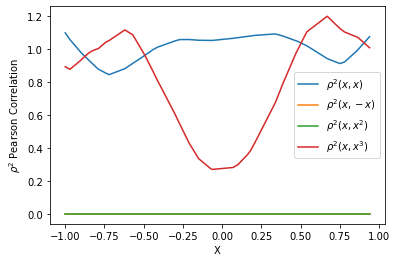

In [53]:
# How confusing!
C_test = np.sort(C_test, axis=0)
corrs = model.predict_correlation(C_test)
plt.plot(C_test, corrs[:,0,0], label=r'$\rho^2(x, x)$')
plt.plot(C_test, corrs[:,0,1], label=r'$\rho^2(x, -x)$')
plt.plot(C_test, corrs[:,0,2], label=r'$\rho^2(x, x^2)$')
plt.plot(C_test, corrs[:,0,3], label=r'$\rho^2(x, x^3)$')
plt.ylabel(r'$\rho^2$ Pearson Correlation')
plt.xlabel('X')
plt.legend()
plt.show()